# Exciton-Polaritons in Lattices

**by Dmitry R. Gulevich <br>
ITMO University, St Petersburg, Russia**

Python code to simulate exciton-polaritons in lattices.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import exp2d
%matplotlib inline

In [2]:
import imp
imp.reload(exp2d)

<module 'exp2d' from '/home/dimitry/Desktop/RESEARCH 2018/SpinorGP code/exp2d/exp2d.py'>

# 1. Setting up the model

In [3]:
me=9.1e-31 # electron mass, kg
meff=5.0e-5*me # exciton-polariton effective mass, kg
hbar=1.05e-34 # reduced Planck constant, J s
dum=3. # micron
d=dum*1.e-6 # m
E0=hbar*hbar/(2.*meff*d*d)/(1.6e-22) # characteristic energy, meV
print('E0 = %f meV' % E0)

E0 = 0.084135 meV


In [4]:
M=20 # should be even number
assert M%2==0
Umax=20. # height of the potential
aum = 2.9 # um
dum = 3.0 # um
Rpillar=0.5*dum/(2.*aum) # in units of lattice constant

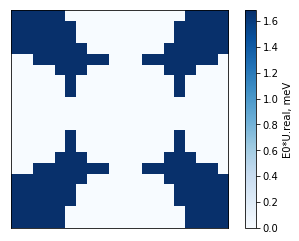

In [5]:
dr=1./M
dr2=dr*dr

U = Umax*exp2d.U_Lieb(M,Rpillar) # create potential

cmap=plt.get_cmap('Blues')
data=E0*U.real
img=plt.imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
plt.xticks([])
plt.yticks([])
plt.colorbar(img,cmap=cmap,label='E0*U.real, meV')
plt.show()

# 2. Band structure and eigenstates

In [6]:
# Calculate eigenenergies for ky=np.pi, NBzones=2, Nvals=30, Nkpoints=70
%time kxrange,evlist=exp2d.calc_bands(M, U, np.pi, 2, 30, 70)

CPU times: user 3.53 s, sys: 32.1 ms, total: 3.56 s
Wall time: 1.79 s


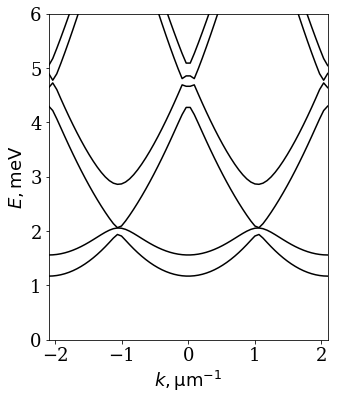

In [7]:
### Source: cbands.py

plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(figsize=(5,6))

for i in range(evlist.shape[1]):
    ax.plot(kxrange/dum,E0*evlist[:,i],'k')

ax.set_xlim([kxrange[0]/dum,kxrange[-1]/dum])
ax.set_ylim([0,6])
ax.set_xlabel(r"$k, \rm \mu m^{-1}$")
ax.set_ylabel(r"$E, \rm meV$")
ax.set_xticks([-2,-1,0,1,2])
plt.show()

In [8]:
evals,evecs = exp2d.calc_vectors(M, U, np.pi, np.pi, 30)

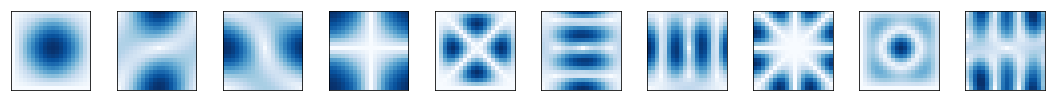

In [9]:
nvmax=10 # number of eigenvectors to display
plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(1,nvmax,figsize=(15,2))

cmap=plt.get_cmap('Blues')

for nv in range(nvmax):
    data=np.abs(evecs[nv]).reshape(M,M)
    ax[nv].imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
    ax[nv].set_xticks([])
    ax[nv].set_yticks([])

plt.tight_layout()
plt.show()

# 3. Dynamics

In [10]:
nv=4
Ncells=5 # integer number for symmetric display
Mglobal=Ncells*M

Uglobal=np.zeros((Mglobal,Mglobal),dtype=np.complex128)
for i in range(Ncells):
    for j in range(Ncells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = U[:,:]
        
Psi=np.zeros((Ncells*M,Ncells*M),dtype=np.complex128)

psi=evecs[nv].reshape(M,M)

kx=0.
ky=0.

for i in range(Ncells):
    for j in range(Ncells):
        Psi[i*M:(i+1)*M,j*M:(j+1)*M] = psi[:,:]*np.exp(1j*(kx*i+ky*j))

print('# Initialized at kx=%f, ky=%f, nv=%d' % (kx,ky,nv))

# Initialized at kx=0.000000, ky=0.000000, nv=4


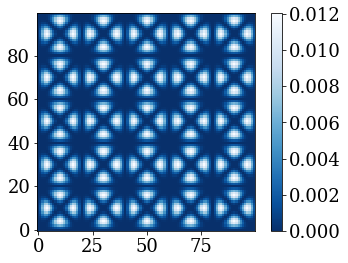

In [11]:
interpolation='nearest'
#interpolation='gaussian'
#interpolation=None
cmap=plt.get_cmap('Blues_r')
data=(Psi*np.conjugate(Psi)).real
img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower')
plt.colorbar(img,cmap=cmap)
plt.show()

In [12]:
from numpy.ctypeslib import ndpointer, load_library
from ctypes import *

### === C library interface ===
libcd = load_library("liblattice.so", ".")
libcd.lattice.restype = None
libcd.lattice.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
        c_int, c_int, c_double, c_double, c_int, c_int,
        ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS')]

libcd.omp_set_num_threads(2) # set number of OpenMP threads

#dt=0.002
dt=0.001
dtout=0.05
tstart=0.
countout=int(dtout/dt)
Nframes=50
NPKY=6

FPsiarr=np.empty((Nframes,NPKY,Mglobal),dtype=np.complex128)

#libcd.lattice(Psi,FPsiarr,Ncells,Mhalf,tstart,dt,Nframes,countout,Uglobal)
